In [1]:
!pip install kaggle

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [5]:
# Suppose you uploaded kaggle.json to: /content/drive/MyDrive/kaggle/kaggle.json
! mkdir -p ~/.kaggle
! cp /content/drive/MyDrive/kaggle.json ~/.kaggle/
! chmod 600 ~/.kaggle/kaggle.json


In [6]:
# 3. Download the dataset
! kaggle datasets download zaidpy/oral-cancer-dataset

# 4. Unzip it
! unzip oral-cancer-dataset.zip -d /content/oral_cancer_dataset


Dataset URL: https://www.kaggle.com/datasets/zaidpy/oral-cancer-dataset
License(s): apache-2.0
 89% 279M/315M [00:00<00:00, 703MB/s] 
100% 315M/315M [00:00<00:00, 739MB/s]
Archive:  oral-cancer-dataset.zip
  inflating: /content/oral_cancer_dataset/Oral Cancer/Oral Cancer Dataset/CANCER/001.jpeg  
  inflating: /content/oral_cancer_dataset/Oral Cancer/Oral Cancer Dataset/CANCER/002.jpeg  
  inflating: /content/oral_cancer_dataset/Oral Cancer/Oral Cancer Dataset/CANCER/003.jpeg  
  inflating: /content/oral_cancer_dataset/Oral Cancer/Oral Cancer Dataset/CANCER/004.jpeg  
  inflating: /content/oral_cancer_dataset/Oral Cancer/Oral Cancer Dataset/CANCER/005.jpeg  
  inflating: /content/oral_cancer_dataset/Oral Cancer/Oral Cancer Dataset/CANCER/006.jpeg  
  inflating: /content/oral_cancer_dataset/Oral Cancer/Oral Cancer Dataset/CANCER/007.jpeg  
  inflating: /content/oral_cancer_dataset/Oral Cancer/Oral Cancer Dataset/CANCER/008.jpeg  
  inflating: /content/oral_cancer_dataset/Oral Cancer/Oral

In [7]:
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator

data_dir = "/content/oral_cancer_dataset/Oral Cancer/Oral Cancer Dataset"

# Data generators
train_datagen = ImageDataGenerator(
    rescale=1./255,
    validation_split=0.2,
    rotation_range=15,
    zoom_range=0.2,
    horizontal_flip=True,
)

train_data = train_datagen.flow_from_directory(
    data_dir,
    target_size=(224, 224),
    batch_size=32,
    class_mode='categorical',
    subset='training'
)

val_data = train_datagen.flow_from_directory(
    data_dir,
    target_size=(224, 224),
    batch_size=32,
    class_mode='categorical',
    subset='validation'
)


Found 600 images belonging to 2 classes.
Found 150 images belonging to 2 classes.


In [8]:
from tensorflow.keras.applications import MobileNetV2
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D, Dropout
from tensorflow.keras.models import Model

base_model = MobileNetV2(weights='imagenet', include_top=False, input_shape=(224, 224, 3))

x = base_model.output
x = GlobalAveragePooling2D()(x)
x = Dropout(0.3)(x)
x = Dense(128, activation='relu')(x)
output = Dense(2, activation='softmax')(x)

model = Model(inputs=base_model.input, outputs=output)

# Freeze base layers for transfer learning
for layer in base_model.layers:
    layer.trainable = False

model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

model.summary()


9406464/9406464 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step


Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer         │ (None, 224, 224,  │          0 │ -                 │
│ (InputLayer)        │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ Conv1 (Conv2D)      │ (None, 112, 112,  │        864 │ input_layer[0][0] │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ bn_Conv1            │ (None, 112, 112,  │        128 │ Conv1[0][0]       │
│ (BatchNormalizatio… │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ Conv1_relu (ReLU)   │ (None, 112, 112,  │          0 │ bn_Conv1[0][0]    │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ expanded_conv_dept… │ (None, 112, 112,  │        288 │ Conv1_relu[0][0]  │
│ (DepthwiseConv2D)   │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ expanded_conv_dept… │ (None, 112, 112,  │        128 │ expanded_conv_de… │
│ (BatchNormalizatio… │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ expanded_conv_dept… │ (None, 112, 112,  │          0 │ expanded_conv_de… │
│ (ReLU)              │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ expanded_conv_proj… │ (None, 112, 112,  │        512 │ expanded_conv_de… │
│ (Conv2D)            │ 16)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ expanded_conv_proj… │ (None, 112, 112,  │         64 │ expanded_conv_pr… │
│ (BatchNormalizatio… │ 16)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_expand      │ (None, 112, 112,  │      1,536 │ expanded_conv_pr… │
│ (Conv2D)            │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_expand_BN   │ (None, 112, 112,  │        384 │ block_1_expand[0… │
│ (BatchNormalizatio… │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_expand_relu │ (None, 112, 112,  │          0 │ block_1_expand_B… │
│ (ReLU)              │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_pad         │ (None, 113, 113,  │          0 │ block_1_expand_r… │
│ (ZeroPadding2D)     │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_depthwise   │ (None, 56, 56,    │        864 │ block_1_pad[0][0] │
│ (DepthwiseConv2D)   │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_depthwise_… │ (None, 56, 56,    │        384 │ block_1_depthwis… │
│ (BatchNormalizatio… │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_depthwise_… │ (None, 56, 56,    │          0 │ block_1_depthwis… │
│ (ReLU)              │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_project     │ (None, 56, 56,    │      2,304 │ block_1_depthwis

 Total params: 2,422,210 (9.24 MB)

 Trainable params: 164,226 (641.51 KB)

 Non-trainable params: 2,257,984 (8.61 MB)

In [10]:
history = model.fit(
    train_data,
    validation_data=val_data,
    epochs=15,
)


/usr/local/lib/python3.12/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/15
 2/19 ━━━━━━━━━━━━━━━━━━━━ 30s 2s/step - accuracy: 0.5625 - loss: 0.7501  

/usr/local/lib/python3.12/dist-packages/PIL/Image.py:1047: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(


19/19 ━━━━━━━━━━━━━━━━━━━━ 52s 2s/step - accuracy: 0.7300 - loss: 0.5529 - val_accuracy: 0.8400 - val_loss: 0.3633
Epoch 2/15
19/19 ━━━━━━━━━━━━━━━━━━━━ 42s 2s/step - accuracy: 0.8820 - loss: 0.2777 - val_accuracy: 0.9133 - val_loss: 0.2795
Epoch 3/15
19/19 ━━━━━━━━━━━━━━━━━━━━ 41s 2s/step - accuracy: 0.8985 - loss: 0.2763 - val_accuracy: 0.9067 - val_loss: 0.2976
Epoch 4/15
19/19 ━━━━━━━━━━━━━━━━━━━━ 49s 3s/step - accuracy: 0.9323 - loss: 0.1917 - val_accuracy: 0.8867 - val_loss: 0.2837
Epoch 5/15
19/19 ━━━━━━━━━━━━━━━━━━━━ 42s 2s/step - accuracy: 0.9069 - loss: 0.2060 - val_accuracy: 0.9067 - val_loss: 0.2373
Epoch 6/15
19/19 ━━━━━━━━━━━━━━━━━━━━ 43s 2s/step - accuracy: 0.9575 - loss: 0.1350 - val_accuracy: 0.9067 - val_loss: 0.3091
Epoch 7/15
19/19 ━━━━━━━━━━━━━━━━━━━━ 41s 2s/step - accuracy: 0.9298 - loss: 0.1593 - val_accuracy: 0.8867 - val_loss: 0.2699
Epoch 8/15
19/19 ━━━━━━━━━━━━━━━━━━━━ 43s 2s/step - accuracy: 0.9410 - loss: 0.1567 - val_accuracy: 0.8733 - val_loss: 0.3194
Epo

In [11]:
# Unfreeze the last 30 layers of the base model for fine-tuning
for layer in base_model.layers[-30:]:
    layer.trainable = True

# Recompile with a smaller learning rate
from tensorflow.keras.optimizers import Adam
model.compile(
    optimizer=Adam(learning_rate=1e-5),
    loss='categorical_crossentropy',
    metrics=['accuracy']
)

# Fine-tune for a few more epochs
fine_tune_history = model.fit(
    train_data,
    validation_data=val_data,
    epochs=10
)


Epoch 1/10
19/19 ━━━━━━━━━━━━━━━━━━━━ 68s 3s/step - accuracy: 0.8118 - loss: 0.7901 - val_accuracy: 0.8667 - val_loss: 0.4081
Epoch 2/10
19/19 ━━━━━━━━━━━━━━━━━━━━ 49s 3s/step - accuracy: 0.8776 - loss: 0.3708 - val_accuracy: 0.8400 - val_loss: 0.4764
Epoch 3/10
19/19 ━━━━━━━━━━━━━━━━━━━━ 51s 3s/step - accuracy: 0.8632 - loss: 0.3649 - val_accuracy: 0.8133 - val_loss: 0.5183
Epoch 4/10
19/19 ━━━━━━━━━━━━━━━━━━━━ 49s 3s/step - accuracy: 0.9102 - loss: 0.2268 - val_accuracy: 0.8400 - val_loss: 0.5585
Epoch 5/10
19/19 ━━━━━━━━━━━━━━━━━━━━ 51s 3s/step - accuracy: 0.9389 - loss: 0.1766 - val_accuracy: 0.7933 - val_loss: 0.6417
Epoch 6/10
19/19 ━━━━━━━━━━━━━━━━━━━━ 83s 3s/step - accuracy: 0.9118 - loss: 0.2027 - val_accuracy: 0.8067 - val_loss: 0.6854
Epoch 7/10
19/19 ━━━━━━━━━━━━━━━━━━━━ 48s 3s/step - accuracy: 0.9067 - loss: 0.2318 - val_accuracy: 0.8400 - val_loss: 0.5622
Epoch 8/10
19/19 ━━━━━━━━━━━━━━━━━━━━ 82s 3s/step - accuracy: 0.9301 - loss: 0.1865 - val_accuracy: 0.7800 - val_loss:

In [12]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator

train_datagen = ImageDataGenerator(
    rescale=1./255,
    validation_split=0.2,
    rotation_range=25,
    zoom_range=0.3,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.15,
    horizontal_flip=True,
    vertical_flip=True,
    brightness_range=[0.7, 1.3],
)


In [13]:
x = Dropout(0.4)(x)


In [14]:
from tensorflow.keras.regularizers import l2

x = Dense(128, activation='relu', kernel_regularizer=l2(0.001))(x)


In [15]:
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau

callbacks = [
    EarlyStopping(patience=5, restore_best_weights=True),
    ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=3, min_lr=1e-7)
]

model.fit(
    train_data,
    validation_data=val_data,
    epochs=30,
    callbacks=callbacks
)


Epoch 1/30
19/19 ━━━━━━━━━━━━━━━━━━━━ 52s 3s/step - accuracy: 0.9444 - loss: 0.1415 - val_accuracy: 0.8467 - val_loss: 0.4551 - learning_rate: 1.0000e-05
Epoch 2/30
19/19 ━━━━━━━━━━━━━━━━━━━━ 50s 3s/step - accuracy: 0.9497 - loss: 0.0996 - val_accuracy: 0.8400 - val_loss: 0.5402 - learning_rate: 1.0000e-05
Epoch 3/30
19/19 ━━━━━━━━━━━━━━━━━━━━ 52s 3s/step - accuracy: 0.9331 - loss: 0.1615 - val_accuracy: 0.8600 - val_loss: 0.5397 - learning_rate: 1.0000e-05
Epoch 4/30
19/19 ━━━━━━━━━━━━━━━━━━━━ 49s 3s/step - accuracy: 0.9312 - loss: 0.1583 - val_accuracy: 0.8533 - val_loss: 0.4665 - learning_rate: 1.0000e-05
Epoch 5/30
19/19 ━━━━━━━━━━━━━━━━━━━━ 50s 3s/step - accuracy: 0.9487 - loss: 0.1338 - val_accuracy: 0.8467 - val_loss: 0.4221 - learning_rate: 5.0000e-06
Epoch 6/30
19/19 ━━━━━━━━━━━━━━━━━━━━ 48s 3s/step - accuracy: 0.9602 - loss: 0.1174 - val_accuracy: 0.8267 - val_loss: 0.5555 - learning_rate: 5.0000e-06
Epoch 7/30
19/19 ━━━━━━━━━━━━━━━━━━━━ 52s 3s/step - accuracy: 0.9548 - loss:

In [16]:
from sklearn.metrics import classification_report, confusion_matrix
import numpy as np

Y_pred = model.predict(val_data)
y_pred = np.argmax(Y_pred, axis=1)

print("Classification Report:\n")
print(classification_report(val_data.classes, y_pred, target_names=list(val_data.class_indices.keys())))

print("\nConfusion Matrix:\n")
print(confusion_matrix(val_data.classes, y_pred))


5/5 ━━━━━━━━━━━━━━━━━━━━ 18s 2s/step
Classification Report:

              precision    recall  f1-score   support

      CANCER       0.68      0.56      0.62       100
  NON CANCER       0.35      0.48      0.41        50

    accuracy                           0.53       150
   macro avg       0.52      0.52      0.51       150
weighted avg       0.57      0.53      0.55       150


Confusion Matrix:

[[56 44]
 [26 24]]


In [17]:
model.save("/content/oral_cancer_detector_v2.h5")


1/1 ━━━━━━━━━━━━━━━━━━━━ 5s 5s/step


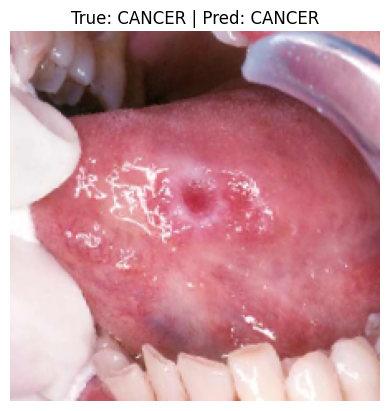

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step


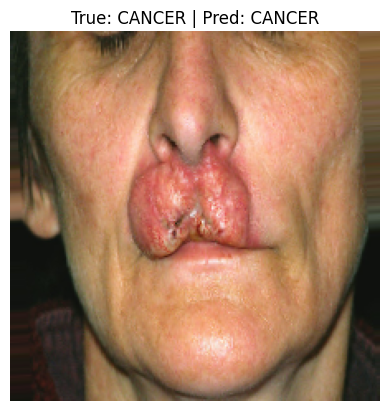

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step


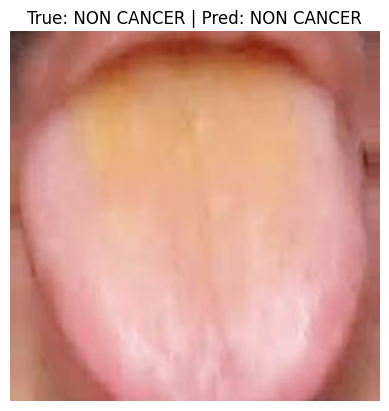

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step


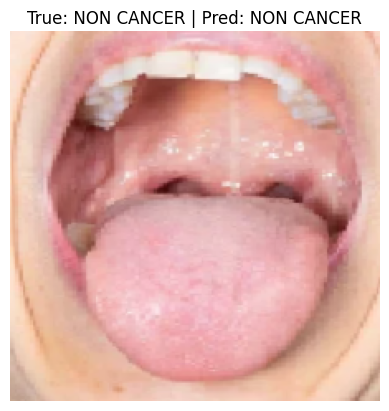

1/1 ━━━━━━━━━━━━━━━━━━━━ 3s 3s/step


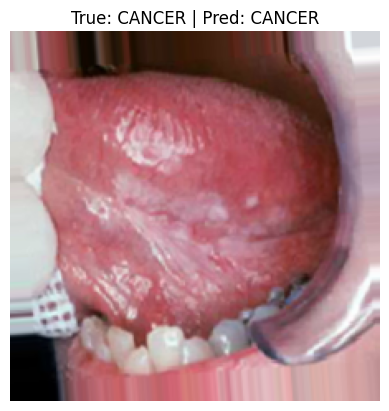

In [19]:
import matplotlib.pyplot as plt
import numpy as np
import tensorflow as tf

class_labels = list(val_data.class_indices.keys())

for i in range(5):
    img, label = next(val_data)  # ✅ Correct way
    preds = model.predict(img)
    plt.imshow(img[0])
    plt.title(
        f"True: {class_labels[np.argmax(label[0])]} | Pred: {class_labels[np.argmax(preds[0])]}"
    )
    plt.axis("off")
    plt.show()


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 271ms/step


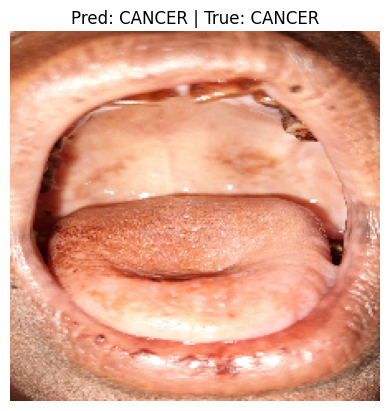

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 227ms/step


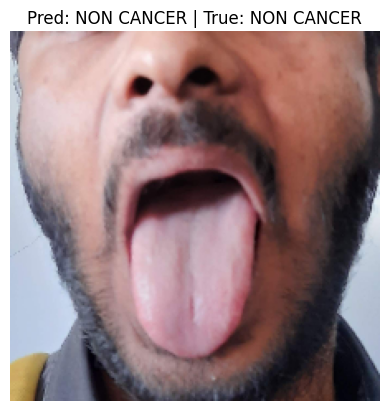

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 132ms/step


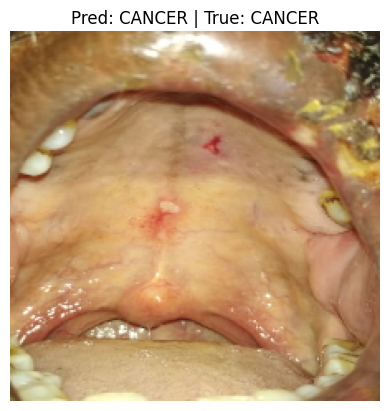

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 246ms/step


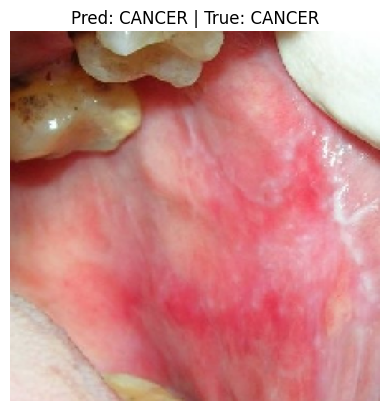

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 158ms/step


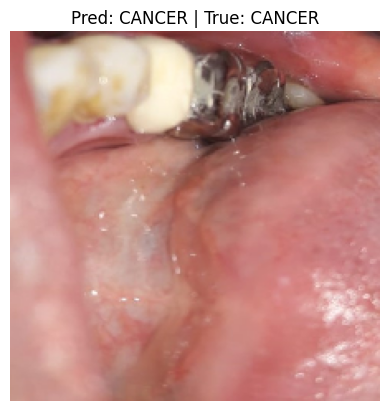

In [20]:
import random
import os
from tensorflow.keras.preprocessing import image

data_dir = val_data.directory
categories = list(val_data.class_indices.keys())

for i in range(5):
    category = random.choice(categories)
    folder = os.path.join(data_dir, category)
    img_path = os.path.join(folder, random.choice(os.listdir(folder)))

    img = image.load_img(img_path, target_size=(224,224))
    img_array = image.img_to_array(img) / 255.0
    img_array = np.expand_dims(img_array, axis=0)

    preds = model.predict(img_array)
    pred_class = categories[np.argmax(preds)]

    plt.imshow(img)
    plt.title(f"Pred: {pred_class} | True: {category}")
    plt.axis("off")
    plt.show()
